<a href="https://colab.research.google.com/github/yukiao/Pengantar-Deep-Learning/blob/main/Week5/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Silverius Sony Lembang  
NIM: H071191002

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from datetime import  datetime
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.1

# Architecture


In [3]:
def conv_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels), nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
  )

In [4]:
class DenseBlock(nn.Module):
  def __init__(self, num_convs, input_channels, num_channels):
    super(DenseBlock, self).__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(
          num_channels * i + input_channels, num_channels
      ))
    self.net = nn.Sequential(*layer)
  
  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X,Y), dim=1)
    return X

In [5]:
def transition_block(input_channels, num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),
      nn.ReLU(),
      nn.Conv2d(input_channels, num_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
  )

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), 
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [7]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  num_channels += num_convs * growth_rate

  if i != len(num_convs_in_dense_blocks) - 1 :
    blks.append(transition_block(num_channels, num_channels // 2))
    num_channels = num_channels // 2

In [8]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

# Helpers

In [9]:
# Get accuracy on training
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [10]:
def plot_train(train_losses, train_accuracies):
  train_losses = torch.tensor(train_losses, device='cpu')
  train_accuracies = torch.tensor(train_accuracies, device='cpu')

  train_losses = train_losses.numpy()
  train_accuracies = train_accuracies.numpy()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

  ax[0].plot(train_losses, color="red", label="Training Loss")
  ax[0].set(title="Training Loss over epochs", xlabel="Epoch", ylabel="Loss")
  ax[0].legend()

  ax[1].plot(train_accuracies, color="blue", label="Training Accuracy")
  ax[1].set(title="Training Accuracy over epochs", xlabel="Epoch", ylabel="Accuracy")
  ax[1].legend()

  fig.show()

In [11]:
def train(model, train_loader, criterion, optimizer, device):
  model.train()

  for X, y_true in train_loader:
    optimizer.zero_grad()
    running_loss = 0

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward pass
    y_hat = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward pass
    loss.backward()
    optimizer.step()
  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [12]:
def training_loop(model, criterion, optimizer, train_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    print("Start Training")
    print(f"Using {device} device")
    # Train model

    train_losses = []
    train_accuracies = []

    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accuracies.append(train_acc)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Loss: {train_loss:.4f}\t'
                  f'Accuracy: {100 * train_acc:.2f}%\t')
    plot_train(train_losses, train_accuracies)
    print("Finish")
    return model, optimizer

In [13]:
def imshow(img, title, index):
  plt.subplot(1,5,index)
  plt.axis('off')
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = np.clip(npimg, 0,1)
  plt.title(title)
  plt.imshow(img.reshape((96, 96)), cmap='gray')

# Training

In [14]:
train_dataset = datasets.MNIST("./data",
                                 train=True,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                 ]),
                                 download = True)

test_dataset = datasets.MNIST("./data",
                                 train = False,
                                 transform = transforms.Compose([
                                    transforms.Resize((96, 96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1325,), (0.3105,))
                                 ]),
                                 download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [16]:
torch.manual_seed(RANDOM_SEED)
model = net.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Start Training
Using cuda device
07:12:19 --- Epoch: 0	Loss: 0.0002	Accuracy: 95.07%	
07:14:03 --- Epoch: 1	Loss: 0.0001	Accuracy: 94.00%	
07:15:47 --- Epoch: 2	Loss: 0.0001	Accuracy: 97.84%	
07:17:30 --- Epoch: 3	Loss: 0.0000	Accuracy: 98.77%	
07:19:14 --- Epoch: 4	Loss: 0.0000	Accuracy: 99.00%	
07:20:58 --- Epoch: 5	Loss: 0.0000	Accuracy: 98.11%	
07:22:41 --- Epoch: 6	Loss: 0.0001	Accuracy: 98.44%	
07:24:25 --- Epoch: 7	Loss: 0.0001	Accuracy: 99.15%	
07:26:09 --- Epoch: 8	Loss: 0.0000	Accuracy: 99.26%	
07:27:52 --- Epoch: 9	Loss: 0.0000	Accuracy: 99.05%	
Finish


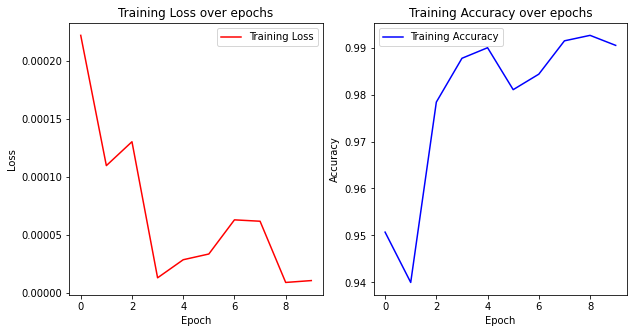

In [17]:
model, optimizer = training_loop(model, criterion, optimizer, train_loader, NUM_EPOCHS, device)

# Testing

In [18]:
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {format(100 * correct / total)} %')

Accuracy of the network on the 10000 test images: 98.96 %


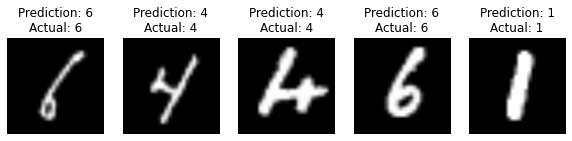

In [21]:
inputs, classes = next(iter(test_loader))
original_inputs = inputs
original_classes = classes

inputs = inputs.to(device)
classes = classes.to(device)

correct = 0

fig = plt.figure(figsize=(10,10))
for i in range(5):
  with torch.no_grad():
    model.eval()
    output = model(inputs[i].reshape(1, 1, 96, 96))
    out = output.cpu().data.numpy().argmax()
    predicted = out.item()
    correct = out == classes[i].item()
    imshow(original_inputs[i], f"Prediction: {predicted}\nActual: {classes[i].item()}", i+1)

plt.show()

In [22]:
# lr, num_epochs, batch_size = 0.1, 10, 256
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())